### Load required packages

# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified deterministic model (1)

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook was made to quickly perform scenario analysis with the age-stratified model implementation.

In [1]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
import math
import xarray as xr
import emcee
from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC

### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

In [35]:
params = parameters.get_COVID19_SEIRD_parameters()
params.update({'l': 1,
              'tau': 5})
initial_states = {'S': initN, 'E': np.ones(levels)}
from covid19model.models.compliance import ramp_2
model = models.COVID19_SEIRD(initial_states, params, compliance=ramp_2)

### Scrape high-level Sciensano data

In [6]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.head()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-03-15,266,54,71,18,53,6,0.0,0.0,3.0,1,2
2020-03-16,370,79,90,14,129,11,0.0,0.0,3.0,3,5
2020-03-17,497,100,122,31,220,12,0.0,0.0,1.0,4,7
2020-03-18,650,131,179,48,351,22,1.0,1.0,2.0,6,10
2020-03-19,844,165,207,49,509,28,0.0,0.0,8.0,5,14


### Calibrating $\beta$ and lag_time

**Skip this section when parameters were previously calibrated**

Use the function fit_pso to obtain a good first estimate for the MCMC sampler.

In [8]:
# define dataset
data=[df_sciensano["H_in"].values[:8]]
# set optimisation settings
parNames = ['sigma_H_in','extraTime','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(30,60),(0.02,0.06)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=50,popsize=50)

No constraints given.
New best for swarm at iteration 1: [47.44266346 38.72091249  0.04904755] 34.22113115511782
Best after iteration 1: [47.44266346 38.72091249  0.04904755] 34.22113115511782
Best after iteration 2: [47.44266346 38.72091249  0.04904755] 34.22113115511782
Best after iteration 3: [47.44266346 38.72091249  0.04904755] 34.22113115511782
New best for swarm at iteration 4: [4.77038987e+01 4.10172645e+01 4.64879928e-02] 34.139570270895035
Best after iteration 4: [4.77038987e+01 4.10172645e+01 4.64879928e-02] 34.139570270895035
New best for swarm at iteration 5: [5.38071489e+01 4.52968450e+01 4.26751473e-02] 33.86940608511712
Best after iteration 5: [5.38071489e+01 4.52968450e+01 4.26751473e-02] 33.86940608511712
Best after iteration 6: [5.38071489e+01 4.52968450e+01 4.26751473e-02] 33.86940608511712
Best after iteration 7: [5.38071489e+01 4.52968450e+01 4.26751473e-02] 33.86940608511712
Best after iteration 8: [5.38071489e+01 4.52968450e+01 4.26751473e-02] 33.86940608511712


In [9]:
lag_time = int(round(theta[1]))
model.extraTime = int(round(theta[1]))

model.parameters.update({
    'beta': theta[2],
}
)

start_date = '15-03-2020'

Initiatize and run the MCMC sampler

In [10]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.01,0.10))

pos = [theta[0],theta[2]] + [1, 1e-2 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [19:49<00:00,  8.41it/s]


In [12]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [11]:
sampler.get_autocorr_time()

array([46.31928841, 42.40775327])

In [17]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.036797032888574194 0.03644383619683572 0.03715703043106455


Initialize a dictionary of samples and write them to `parameters.json`

In [13]:
samples_dict={'lag_time': int(round(theta[1])), 'beta': flat_samples[:,1].tolist()}

In [14]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

Make some diagnostic visualisations

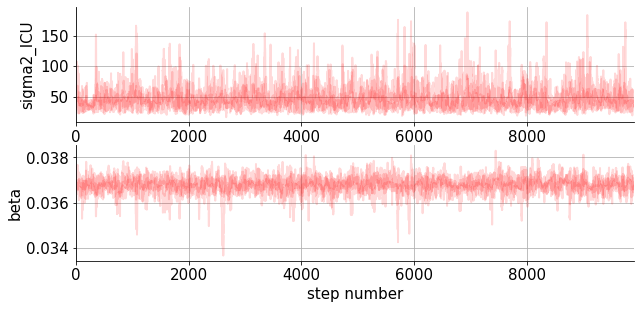

In [15]:
traceplot(samples,labels=["sigma2_ICU","beta"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

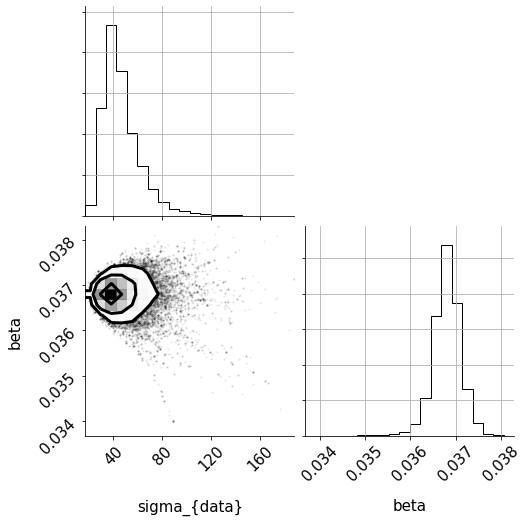

In [16]:
import corner

fig = corner.corner(
    flat_samples,labels=['sigma_{data}','beta']
);
fig.set_size_inches(8, 8)
plt.savefig('corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

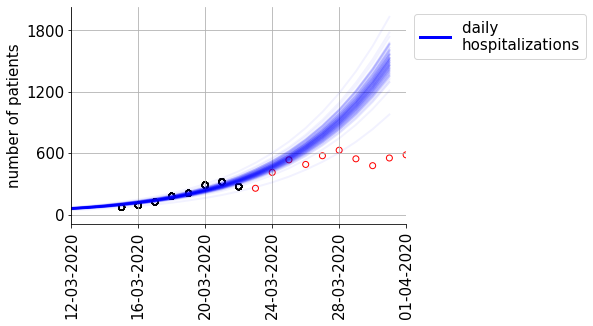

In [18]:
T = 9
fig,ax=plt.subplots()

for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    y_model = model.sim(data[0].size+lag_time-1+T)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][8:18].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][8:18], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
plt.savefig('plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Calibrating the compliance function parameter l

#### Loading $\beta$ and lag_time

Load the previously calibrated parameters.

In [19]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

In [20]:
samples_beta = {'beta': samples_dict['beta']}

#### Initial guess for MCMC with PSO

In [39]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [0.2*Nc_home + ((1-0.70)*Nc_work + (1-0.80)*Nc_transport)],
      }
# checkpoints are hardcoded!

# define dataset
data=[df_sciensano["H_in"].values[:37]]
# set optimisation settings
parNames = ['sigma_H_in','l','tau','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(0.1,20),(0,20),(0,1)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,samples=samples_beta,maxiter=200,popsize=100)

No constraints given.
Best after iteration 1: [47.62577426  4.13010279  5.40958225  0.17110717] 184.16062268410738
Best after iteration 2: [47.62577426  4.13010279  5.40958225  0.17110717] 184.16062268410738
Best after iteration 3: [47.62577426  4.13010279  5.40958225  0.17110717] 184.16062268410738
New best for swarm at iteration 4: [52.42449134  0.1         5.15219859  0.35804932] 170.6792383230492
Best after iteration 4: [52.42449134  0.1         5.15219859  0.35804932] 170.6792383230492
Best after iteration 5: [52.42449134  0.1         5.15219859  0.35804932] 170.6792383230492
New best for swarm at iteration 6: [73.64531883  0.1         6.66624197  0.33092887] 170.57429299605283
Best after iteration 6: [73.64531883  0.1         6.66624197  0.33092887] 170.57429299605283
New best for swarm at iteration 7: [69.66487784  0.1         6.56977828  0.24336758] 170.52613192898423
Best after iteration 7: [69.66487784  0.1         6.56977828  0.24336758] 170.52613192898423
Best after iterati

Best after iteration 69: [57.19109181  3.0268266   5.16717139  0.29628023] 166.8000673356212
Best after iteration 70: [57.19109181  3.0268266   5.16717139  0.29628023] 166.8000673356212
Best after iteration 71: [57.19109181  3.0268266   5.16717139  0.29628023] 166.8000673356212
Best after iteration 72: [57.19109181  3.0268266   5.16717139  0.29628023] 166.8000673356212
Best after iteration 73: [57.19109181  3.0268266   5.16717139  0.29628023] 166.8000673356212
Best after iteration 74: [57.19109181  3.0268266   5.16717139  0.29628023] 166.8000673356212
Best after iteration 75: [57.19109181  3.0268266   5.16717139  0.29628023] 166.8000673356212
Best after iteration 76: [57.19109181  3.0268266   5.16717139  0.29628023] 166.8000673356212
Best after iteration 77: [57.19109181  3.0268266   5.16717139  0.29628023] 166.8000673356212
New best for swarm at iteration 78: [57.17671836  3.0354256   5.22140321  0.29640009] 166.79302657527882
Best after iteration 78: [57.17671836  3.0354256   5.22140

Best after iteration 147: [56.51954365  3.02280783  5.22826543  0.29324456] 166.73569983797597
Best after iteration 148: [56.51954365  3.02280783  5.22826543  0.29324456] 166.73569983797597
Best after iteration 149: [56.51954365  3.02280783  5.22826543  0.29324456] 166.73569983797597
New best for swarm at iteration 150: [56.44783573  3.02668785  5.23372834  0.29282124] 166.73231917247995
Best after iteration 150: [56.44783573  3.02668785  5.23372834  0.29282124] 166.73231917247995
Best after iteration 151: [56.44783573  3.02668785  5.23372834  0.29282124] 166.73231917247995
Best after iteration 152: [56.44783573  3.02668785  5.23372834  0.29282124] 166.73231917247995
Best after iteration 153: [56.44783573  3.02668785  5.23372834  0.29282124] 166.73231917247995
Best after iteration 154: [56.44783573  3.02668785  5.23372834  0.29282124] 166.73231917247995
Best after iteration 155: [56.44783573  3.02668785  5.23372834  0.29282124] 166.73231917247995
Best after iteration 156: [56.44783573 

In [42]:
model.parameters.update({
    'l': theta[1],

}
)
prevention = theta[2]
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }

In [45]:
bounds=((1,100),(0.001,20),(0,20),(0,1)) # must be a list!
pos = theta + [1, 0.1, 0.1, 0.1 ]* np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk,samples_beta))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [1:02:28<00:00,  2.67it/s]


In [46]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [154.59226063 219.38511983 230.68670849 217.46005082]

In [47]:
samples = sampler.get_chain(discard=300,flat=False)
flat_samples = sampler.get_chain(discard=300,flat=True)

In [48]:
samples_dict.update({'l': flat_samples[:,1].tolist(),'tau':flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist()})

In [49]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [59]:
mean = np.mean(flat_samples[:,3])
p10 = np.percentile(flat_samples[:,3],10)
p90 = np.percentile(flat_samples[:,3],90)
print(mean,p10,p90)

0.2823157495035755 0.24496850754638402 0.3203760894163795


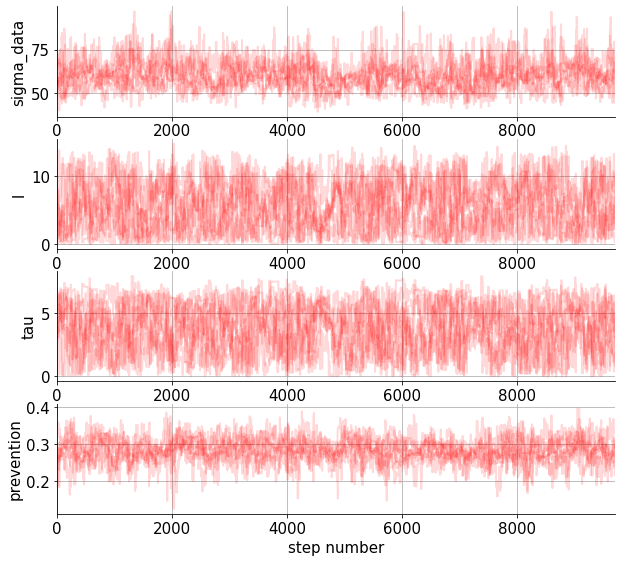

In [50]:
traceplot(samples=sampler.get_chain(discard=300),labels=["sigma_data","l","tau","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

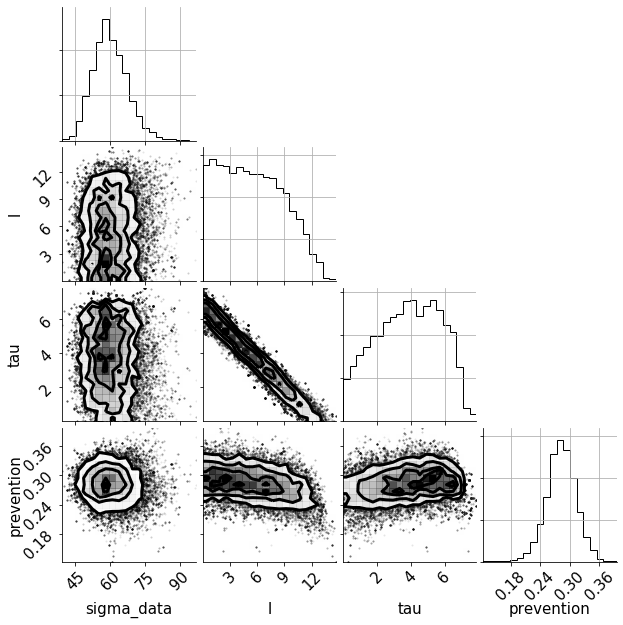

In [51]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_data","l","tau","prevention"],
);
fig.set_size_inches(9, 9)
plt.savefig('corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

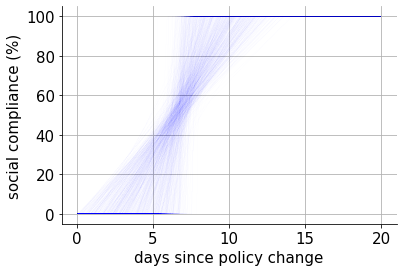

In [55]:
fig,ax=plt.subplots()
t = np.linspace(0,20,400)
for i in range(1000):
    idx,l= random.choice(list(enumerate(flat_samples[:,1])))
    tau = samples_dict['tau'][idx]
    y=[]
    for j in range(len(t)):
        y.append(100*ramp_2(t[j],0,1,l,tau))
    ax.plot(t,y,color='blue',linewidth=0.1,alpha=0.05)
ax.set_xlabel('days since policy change')
ax.set_ylabel('social compliance (%)')
plt.savefig('compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

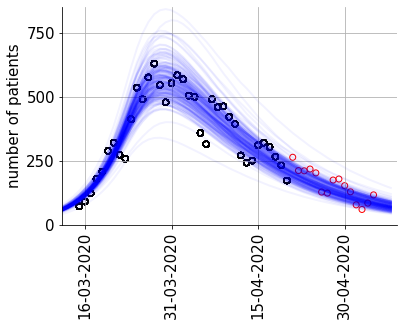

In [60]:
import random
T = 18
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(200):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(flat_samples[:,1])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.00*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][37:52].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][37:52], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Calibration of hospitalization parameters

Load the previously calibrated parameters: $\beta$, lag_time, k, t0, prevention

In [61]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
prevention = np.mean(samples_dict['prevention'])

In [62]:
# Create checkpoints dictionary
chk = {'time':  [lag_time], 
       'Nc':    [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }

model.parameters['dICUrec'] = 8

# define dataset
data=[df_sciensano["H_out"].values[:55],df_sciensano["ICU_tot"].values[:55],df_sciensano["H_tot"].values[:55]]
# set optimisation settings
parNames = ['sigma_H_out','sigma_ICU_tot','sigma_H_tot','dc','dICU'] # must be a list!
states = [["H_out"],["ICU"],["H_tot"]]
bounds=((1,200),(1,300),(1,600),(2,30),(2,20)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,checkpoints=chk,maxiter=50,popsize=50)

No constraints given.
New best for swarm at iteration 1: [149.07037906 233.75258012 341.40587512  15.00999791   9.48748352] 933.5509411365501
Best after iteration 1: [149.07037906 233.75258012 341.40587512  15.00999791   9.48748352] 933.5509411365501
Best after iteration 2: [149.07037906 233.75258012 341.40587512  15.00999791   9.48748352] 933.5509411365501
New best for swarm at iteration 3: [132.39443374 248.3966681  342.21797221  13.10527492   8.61152885] 931.5331416997437
Best after iteration 3: [132.39443374 248.3966681  342.21797221  13.10527492   8.61152885] 931.5331416997437
Best after iteration 4: [132.39443374 248.3966681  342.21797221  13.10527492   8.61152885] 931.5331416997437
New best for swarm at iteration 5: [109.94686395 255.97891698 205.64063825  15.57373941   8.08543573] 910.3010087558266
Best after iteration 5: [109.94686395 255.97891698 205.64063825  15.57373941   8.08543573] 910.3010087558266
Best after iteration 6: [109.94686395 255.97891698 205.64063825  15.57373

In [63]:
model.parameters.update({
    'dc': theta[3],
    'dICU': theta[4]
}
)

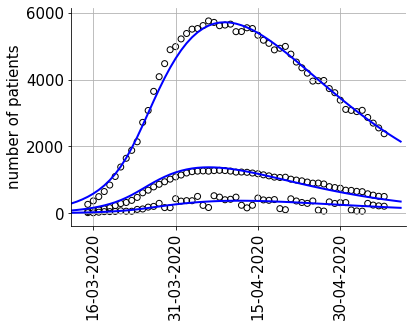

In [64]:
T = 3
fig,ax=plt.subplots()
for i in range(1):
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 1})

In [65]:
pos = theta + [5,5,5,3,3]* np.random.randn(10, 5)
bounds=((1,500),(1,500),(1,1000),(1,30),(1,30)) 
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,chk))
sampler.run_mcmc(pos, 16000, progress=True);

100%|██████████| 16000/16000 [2:44:40<00:00,  1.62it/s]  


In [66]:
sampler.get_autocorr_time()

array([69.18109143, 63.51788537, 66.19165968, 62.44097252, 63.33101562])

In [67]:
samples = sampler.get_chain(discard=50,flat=False)
flat_samples = sampler.get_chain(discard=50,flat=True)

In [72]:
mean = np.mean(samples_dict['dICU'])
p10 = np.percentile(samples_dict['dICU'],10)
p90 = np.percentile(samples_dict['dICU'],90)
print(mean,p10,p90)

8.307525596994928 8.128592958444369 8.484993309942656


In [68]:
samples_dict.update({'dc': flat_samples[:,3].tolist(), 'dICU': flat_samples[:,4].tolist()})

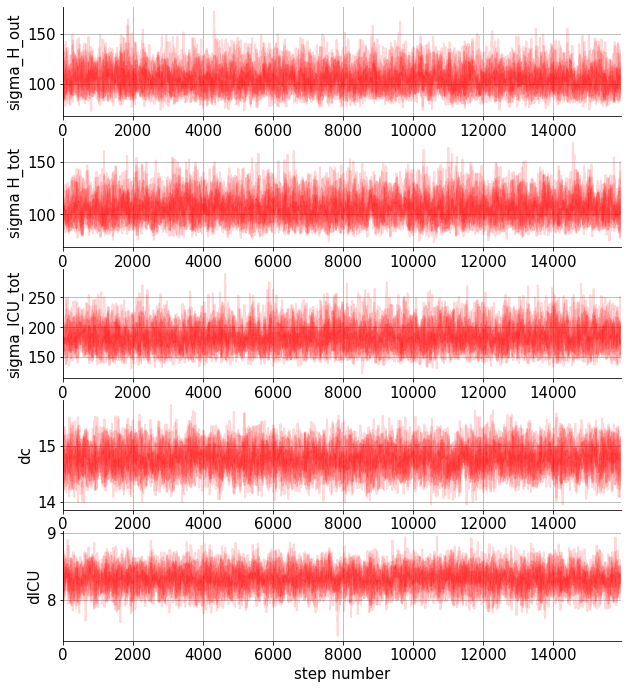

In [69]:
traceplot(samples=sampler.get_chain(discard=50),labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

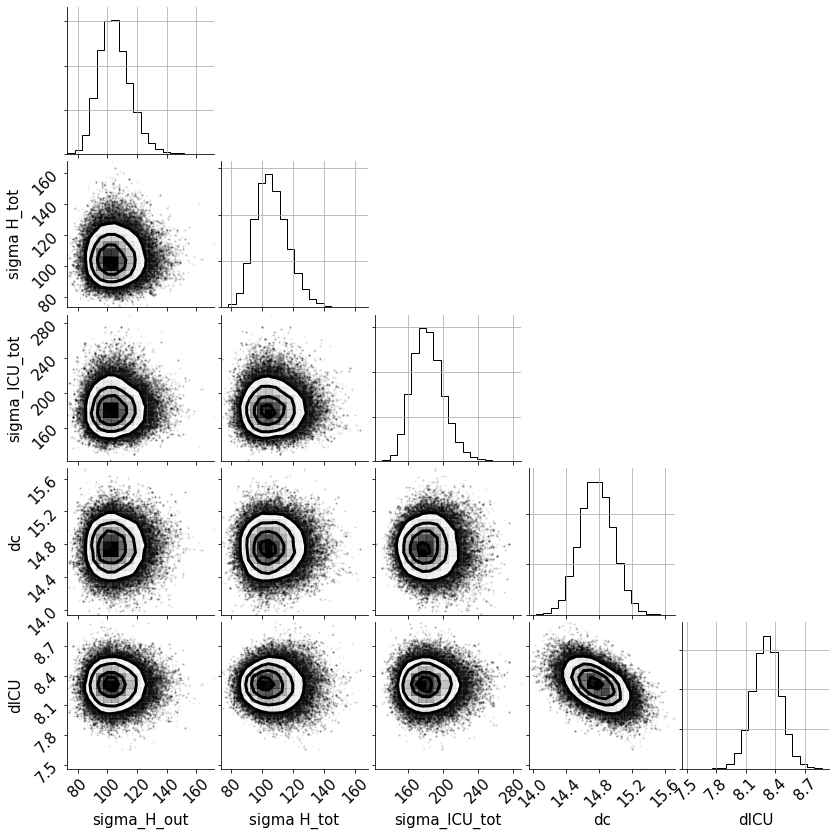

In [70]:
import corner

fig = corner.corner(
    flat_samples, labels=["sigma_H_out","sigma H_tot","sigma_ICU_tot","dc","dICU"],
);
fig.set_size_inches(12, 12)
plt.savefig('corner_compliance_hospitalization.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

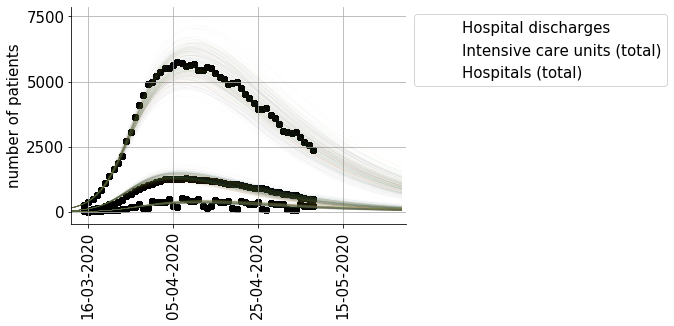

In [35]:
T = 21

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create checkpoints dictionary
    chk = {'time':  [lag_time], 
           'Nc':    [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)],
      }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=['Hospital discharges','Intensive care units (total)','Hospitals (total)'],
                  plt_kwargs={'linewidth': 0.10,'alpha': 0.15})

In [73]:
import json

with open('parameters_deterministic.json', 'w') as fp:
    json.dump(samples_dict, fp)

2.862713861450261 2.8352360735449205 2.890720737931196


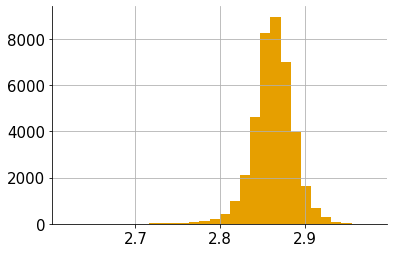

In [23]:
R_0 =[]
for i in range(len(samples_dict['beta'])):
    R_0.append(sum((model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)*(initN/sum(initN))))

plt.hist(R_0,bins=30)
mean = np.mean(R_0)
p10 = np.percentile(R_0,10)
p90 = np.percentile(R_0,90)
print(mean,p10,p90)

1.638331688908891 1.622606145649869 1.654360029660637
2.0070664773881455 1.987801629538611 2.0267022725258252
4.417554332802488 4.375152392932894 4.460772727841083
5.181168950541938 5.1314374480533855 5.2318580399332095
4.071259608476026 4.032181582014586 4.11109008769781
2.990456438306896 2.9617525119877177 3.0197130626650313
1.4782391769972338 1.4640502833303275 1.4927012797581662
0.8372871334139731 0.8292504244094048 0.8454785903529216
0.9278903640509228 0.9189839990222208 0.9369682223600513


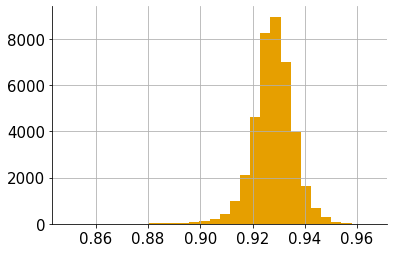

In [30]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)

# Notebook works till here

### Scenarios

In [11]:
import json
with open('parameters_deterministic.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
prevention = np.mean(samples_dict['prevention'])
model.parameters['dc'] = np.mean(samples_dict['dc'])
model.parameters['dICU'] = np.mean(samples_dict['dICU'])

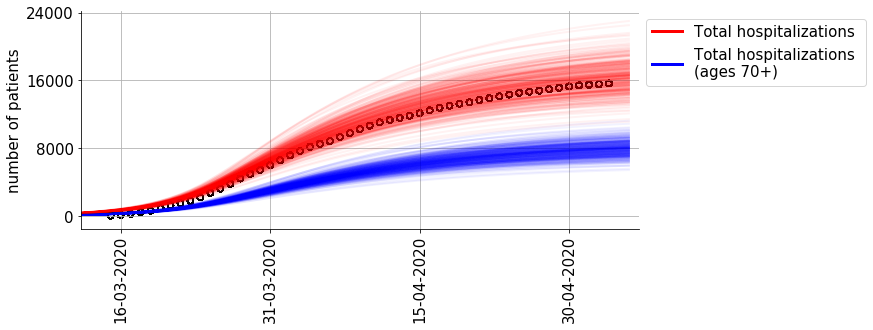

In [77]:
import random
from covid19model.visualization.output import _apply_tick_locator

# define dataset
data=[df_sciensano["H_in"].values[:51]]
states = [["H_in"]]
start_date = '15-03-2020'

T = 2

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    idx,model.parameters['dc'] = random.choice(list(enumerate(samples_dict['dc'])))
    model.parameters['dICU'] = samples_dict['dICU'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    
    # Create shifted index vector 
    idx = pd.date_range(start_date,freq='D',periods=data[0].size + lag_time + T) - datetime.timedelta(days=lag_time)
    # Plot model prediction

    lines = ax.plot([],[],color='red',alpha=1)
    lines = ax.plot([],[],color='blue',alpha=1)
    
    for i in range(len(data)):
        # ages 60 plus
        #data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        #val = y_model[states[i]].to_array(dim="states").values[:,6:,:].sum(axis=1)
        #csum=np.cumsum(val)
        #lines = ax.plot(idx,csum,color='green',linewidth= 2,alpha= 0.05)    
        # ages 70 plus
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values[:,7:,:].sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='blue',linewidth= 2,alpha= 0.05)    
        # total cumsum
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values.sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='red',linewidth= 2,alpha= 0.05)  
    # Plot data
    for i in range(len(data)):
        lines=ax.scatter(idx[lag_time:-T],np.cumsum(data[i]),color="black",facecolors='none')
    

    # Attributes
    #if legend_text is not None:
    #    leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
    #if titleText is not None:
    #    ax.set_title(titleText,{'fontsize':18})

    # Format axes
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
        'rotation', 90)
    #fig.autofmt_xdate(rotation=90)
    ax.set_xlim( idx[lag_time-3], pd.to_datetime(idx[-1]+ datetime.timedelta(days=1)))
    ax.set_ylabel('number of patients')

    # limit the number of ticks on the axis
    ax = _apply_tick_locator(ax)

legend_text=['Total hospitalizations','Total hospitalizations \n(ages 70+)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
fig.set_size_inches(10, 4)
plt.savefig('hospital_age.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

In [13]:
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

In [14]:
T = 62
# Define data as a list containing data timeseries
index = pd.date_range('15-03-2020',freq='D',periods=data[0].size + lag_time + T)
print(index[1],index[50],index[52],index[57],index[64],index[81],index[108],index[170])

2020-03-16 00:00:00 2020-05-04 00:00:00 2020-05-06 00:00:00 2020-05-11 00:00:00 2020-05-18 00:00:00 2020-06-04 00:00:00 2020-07-01 00:00:00 2020-09-01 00:00:00


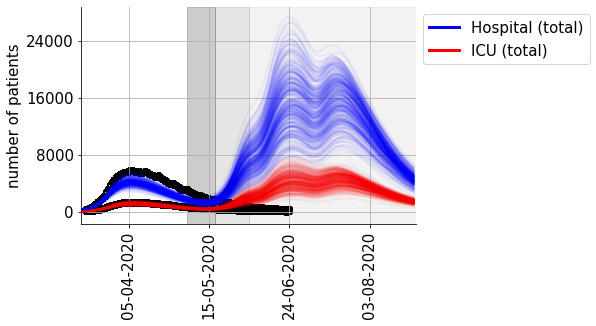

In [15]:
T = 62

fig,ax=plt.subplots()

ax.axvspan(index[50], index[64], alpha=0.20, color='black')
ax.axvspan(index[64], index[81], alpha=0.10, color='black')
ax.axvspan(index[81], index[-1], alpha=0.05, color='black')

for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    #model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    #model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57,lag_time+64,lag_time+81,lag_time+108], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                      prevention*(1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.05})

legend_text=['Hospital (total)','ICU (total)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
#fig.set_size_inches(10, 4)
plt.savefig('lockdown_release.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

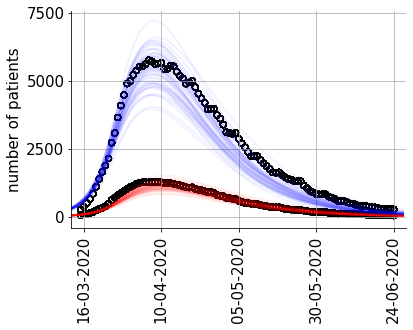

In [38]:
T = 3

fig,ax=plt.subplots()

for i in range(50):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    #model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    #model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                     ]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,'15-03-2020',lag_time,states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.05})

#legend_text=['Hospital (total)','ICU (total)']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
#fig.set_size_inches(6, 4)
plt.savefig('continued_lockdown.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

Text(0, 0.5, "fraction 'immune'")

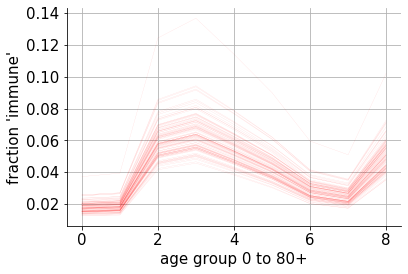

In [22]:
fig,ax=plt.subplots()
for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    model.parameters['l'] = np.random.choice(samples_dict['l'],1,replace=False)
    prevention = np.random.choice(samples_dict['prevention'],1,replace=False)
    model.parameters['dc'] = np.random.choice(samples_dict['dc'],1,replace=False)
    model.parameters['dICU'] = np.random.choice(samples_dict['dICU'],1,replace=False)
    # Create a dictionary of past policies
    chk = {'time':   [lag_time,lag_time+50,lag_time+52,lag_time+57], 
          'Nc':      [prevention*(1.3*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure),
                      prevention*(1.2*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure),
                      prevention*(1.1*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure),
                      prevention*(Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure),]
                              #0.2*Nc_home + prevention*((1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.85)*Nc_schools + (1-0.15)*Nc_others + (1-0.50)*Nc_leisure),
                              #0.2*Nc_home + prevention*((1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.35)*Nc_schools + (1-0.10)*Nc_others + (1-0.30)*Nc_leisure),
                              #0.2*Nc_home + prevention*((1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure)]
                  }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    #ax.plot(1-y_model["S"][:,lag_time+15]/y_model["S"][:,0],alpha=0.2,color='blue',linewidth=0.1)
    ax.plot(1-y_model["S"][:,lag_time+36]/y_model["S"][:,0],alpha=0.2,color='red',linewidth=0.2)
ax.set_xlabel('age group 0 to 80+')
ax.set_ylabel("fraction 'immune'" )